# Телеком


![alt text](https://yamalinternet.ru/wp-content/uploads/cca25c_58d52136fa38426aa01263409bde10demv2.jpg)

In [1]:
!pip install -q psycopg2-binary
!pip install -q torchmetrics

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from tqdm import notebook
from tqdm.auto import tqdm
tqdm.pandas()

import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
import scipy.stats as ss
from torchmetrics.classification import BinaryAccuracy, AUROC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import StandardScaler
from functools import reduce
from sklearn import tree
from sklearn. metrics import precision_recall_curve
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder



RANDOM_STATE = 111223

In [2]:
db_config = {
    # имя пользователя
    'user': 'praktikum_student',
    # пароль,
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    # порт подключения,
    'port': 6432,
    # название базы данных,
    'db': 'data-science-final'}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'])

engine = create_engine(connection_string)

### 1. Знакомство с данными

In [3]:
#загрузим данные
def get_table(table: str):
    query = f'SELECT * FROM {table}'
    data = pd.read_sql_query(query, con=engine,parse_dates={'BeginDate': {'format': '%y%m/%d'},
                                                           'EndDate': {'format': '%y%m/%d'}})
    return data

In [4]:
contract = get_table('telecom.contract')

contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
contract.dtypes

customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [6]:
personal = get_table('telecom.personal')
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
internet = get_table('telecom.internet')
internet.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [8]:
#переименуем столбцы, удалим 0 объект
internet = internet.rename(columns={'c1':'customerID', 'c2':'InternetService', 
                         'c3':'OnlineSecurity', 'c4':'OnlineBackup', 
                         'c5':'DeviceProtection', 'c6':'TechSupport', 
                         'c7':'StreamingTV', 'c8':'StreamingMovies'}).drop([0]).reset_index(drop=True)
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
phone = get_table('telecom.phone')
phone.head()

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


In [10]:
#переименуем столбцы, удалим 0 объект
phone = phone.rename(columns={'c1':'customerID', 'c2':'MultipleLines'}).drop([0]).reset_index(drop=True)
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Вывод:**
- Загрузили данные
- Поправили названия столбцов
- В таблице contract присутствуют пропущенные значения
- Так же возможно в таблице contract итоговая сумма за пользование, не корректна, можно обратить внимание на объект под индексом 2 клиент использовал услуги целый год, но сумма как за 2 месяца
- Все таблицы на месте
***

### 1.1 Исследовательский анализ данных
- Проанализируйте исходные данные. Проверьте:
- Все ли таблицы содержат данные.
- Соответствует ли количество таблиц условию задачи.
- Для каждой таблицы:
    - Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
    - Обработайте аномалии с учётом особенностей услуг телекоммуникации.

In [11]:
def eda(table):
    display(table.head())
    print(f'Размер таблицы: {table.shape}\n')
    print(f'Типы данных таблицы: \n{table.dtypes}\n')
    print(f'Пропусков в таблице: \n{table.isna().sum()}\n')
    print(f'Дубликатов в таблице: {table.duplicated().sum()}\n')
    for column in table.columns:
        print(f'Признак: {column} \nКол-во значений: \n{table[column].value_counts()}')
        print()

**Таблица contract**

In [12]:
eda(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


Размер таблицы: (7043, 8)

Типы данных таблицы: 
customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

Пропусков в таблице: 
customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

Дубликатов в таблице: 0

Признак: customerID 
Кол-во значений: 
7148-XZPHA    1
0654-PQKDW    1
3055-VTCGS    1
0121-SNYRK    1
8404-VLQFB    1
             ..
9507-EXLTT    1
1723-HKXJQ    1
0420-BWTPW    1
9821-POOTN    1
5047-LHVLY    1
Name: customerID, Length: 7043, dtype: int64

Признак: BeginDate 
Кол-во значений: 
2019-03-13    43
2019-03-24    43
2019-03-09    41
2019-04-08    41
2019-04-03    41
              ..
2018-07-18     1
2019-11-22     1
2018-08-18     1

In [13]:
#изучим пропуски
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN


In [14]:
#исправим пропуски
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)
#проверим
contract.isna().sum()

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
dtype: int64

Столбец TotalCharges отвечает за общие расходы абонента. Столбец имеет пропуски, и мы будем считать, что это значит, что клиент за время срока жизни в компании ничего не платил. 

In [16]:
def check_client(index):
    month = contract.iloc[index]['TotalCharges'] // contract.iloc[index]['MonthlyCharges']
    year = 365// (contract.iloc[index]['TotalCharges'] // contract.iloc[index]['MonthlyCharges'])
    end = (contract.iloc[index]['BeginDate'].year + 365//
           (contract.iloc[index]['TotalCharges'] // contract.iloc[index]['MonthlyCharges']))
    print(f'Клинент: {index}')
    print(f'Месяцев использования: {month}')
    print(f'Лет использования: {year}')
    print(f'Год конца тарифа: {end}')
    print(f'Текущий год: {2023}')

In [17]:
#check_client(280)

In [18]:
#check_client(546)

**Вывод:**
- В данном случае  проблемы:
    - Клиент ушел, и у нас пропущенное в EndDate


In [19]:
contract[contract['EndDate'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,0.00
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,0.00
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,0.00
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,0.00
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,0.00
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


In [20]:
#исправим итоговую сумму
def fix_TotalCharges(table):
    condition = table['EndDate'].isna()
    table.loc[condition, 'TotalCharges'] = 0
    return table

In [21]:
#contract = fix_TotalCharges(contract)
#проверим
contract[contract['EndDate'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,0.00
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,0.00
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,0.00
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,0.00
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,0.00
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


In [22]:
#исправим дату конца договора
def to_time(row):
    if row['EndDate'] is None:
        row['target'] = 0
        row['EndDate'] = '2020-02-01'
    return row

In [23]:
contract.EndDate = contract.EndDate.astype(object).where(contract.EndDate.notnull(), None)
contract = contract.progress_apply(to_time, axis=1)
contract['EndDate'] = pd.to_datetime(contract['EndDate'])
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['target'] = contract['target'].fillna(1).astype(int)
contract.head()

  0%|          | 0/7043 [00:00<?, ?it/s]

,BeginDate,EndDate,MonthlyCharges,PaperlessBilling,PaymentMethod,TotalCharges,Type,customerID,target
0,2020-02-01,2020-02-01,52.55,Yes,Bank transfer (automatic),0.00,Two year,4472-LVYGI,0
1,2020-02-01,2020-02-01,20.25,No,Mailed check,0.00,Two year,3115-CZMZD,0
2,2018-08-09,2019-12-01,53.85,Yes,Mailed check,108.15,Month-to-month,3668-QPYBK,1
3,2020-02-01,2020-02-01,80.85,No,Mailed check,0.00,Two year,5709-LVOEQ,0
4,2019-01-26,2019-11-01,70.70,Yes,Electronic check,151.65,Month-to-month,9237-HQITU,1


In [25]:
#contract = contract.progress_apply(fix2_TotalCharges, axis=1)
display(contract.head())
display(contract.tail())

,BeginDate,EndDate,MonthlyCharges,PaperlessBilling,PaymentMethod,TotalCharges,Type,customerID,target
0,2020-02-01,2020-02-01,52.55,Yes,Bank transfer (automatic),0.00,Two year,4472-LVYGI,0
1,2020-02-01,2020-02-01,20.25,No,Mailed check,0.00,Two year,3115-CZMZD,0
2,2018-08-09,2019-12-01,53.85,Yes,Mailed check,108.15,Month-to-month,3668-QPYBK,1
3,2020-02-01,2020-02-01,80.85,No,Mailed check,0.00,Two year,5709-LVOEQ,0
4,2019-01-26,2019-11-01,70.70,Yes,Electronic check,151.65,Month-to-month,9237-HQITU,1


,BeginDate,EndDate,MonthlyCharges,PaperlessBilling,PaymentMethod,TotalCharges,Type,customerID,target
7038,2019-01-21,2020-02-01,21.15,Yes,Bank transfer (automatic),1419.40,Two year,2569-WGERO,0
7039,2019-02-26,2020-02-01,84.80,Yes,Mailed check,1990.50,One year,6840-RESVB,0
7040,2019-09-02,2020-02-01,103.20,Yes,Credit card (automatic),7362.90,One year,2234-XADUH,0
7041,2019-06-26,2020-02-01,29.60,Yes,Electronic check,346.45,Month-to-month,4801-JZAZL,0
7042,2019-04-18,2020-02-01,105.65,Yes,Bank transfer (automatic),6844.50,Two year,3186-AJIEK,0


In [26]:
#проверим временной интервал
print(contract['BeginDate'].min(), contract['BeginDate'].max())
print(contract['EndDate'].min(), contract['EndDate'].max())

2018-04-17 00:00:00 2020-02-01 00:00:00
2019-10-01 00:00:00 2020-02-01 00:00:00


In [27]:
def hist_box(df, col):
    fig,ax = plt.subplots(2,1, sharex=True, figsize=(6,6), 
                          gridspec_kw={'height_ratios': [3, 1]})
    
    sns.histplot(data=df,x=col,bins=100, 
                 ax=ax[0]).set(title=f'Distribution of {col}')
    
    sns.boxplot(data=df, x=col, ax=ax[1])
    
    return plt.show();

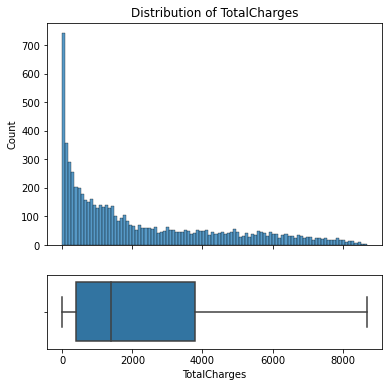

In [28]:
hist_box(contract,'TotalCharges')

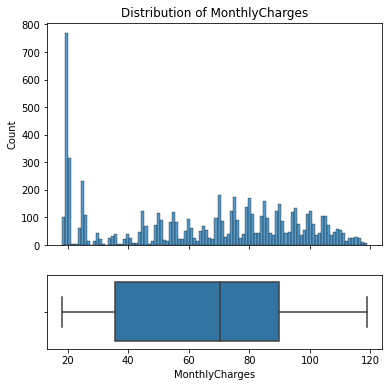

In [29]:
hist_box(contract,'MonthlyCharges')

In [30]:
print(len(contract[contract['TotalCharges'] != 0]))
print(len(contract[contract['TotalCharges'] == 0])) 

7032
11


In [31]:
#2954 / contract.shape[0] * 100, 4089 / contract.shape[0] * 100

contract['PaperlessBilling'].value_counts(normalize=True)

Yes    0.592219
No     0.407781
Name: PaperlessBilling, dtype: float64

**Общий вывод таблица `contract`:**
- Исправили итоговую сумму, где было пропущенное значение в окончании даты договора, итоговая сумма будет равна 0
- Исправили дату коцна договора, если она отсутствует, значит клиент активен, поставим дату начала договора, в дальнейшем пригодиться нам для генерации признака
- Пересчитали итоговую сумму для клиентов, которые платят по месяцам
- Убрали 0 значения случайным образом, получается где 0 значит клиент пользуется услугами, больше 0 клиент ушел, по сути присутствеут дисбаланс классов, 19% активных и 59% неактивных, это нормально в данной отрасли, если бы значение было бы 50/50 значит у фирмы проблемы
***

**Таблица personal**

In [32]:
eda(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Размер таблицы: (7043, 5)

Типы данных таблицы: 
customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

Пропусков в таблице: 
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Дубликатов в таблице: 0

Признак: customerID 
Кол-во значений: 
7148-XZPHA    1
2122-SZZZD    1
7945-PRBVF    1
3071-MVJCD    1
7698-YFGEZ    1
             ..
4487-ZYJZK    1
6434-TTGJP    1
8133-ANHHJ    1
9507-EXLTT    1
5047-LHVLY    1
Name: customerID, Length: 7043, dtype: int64

Признак: gender 
Кол-во значений: 
Male      3555
Female    3488
Name: gender, dtype: int64

Признак: SeniorCitizen 
Кол-во значений: 
0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Признак: Partner 
Кол-во значений: 
No     3641
Yes    3402
Name: Partner, dtype: int64

Признак: Dependents 
Кол-во значений: 
No     4933
Yes    2110
Name: Dependents, dtype: int64



**Общий вывод таблица `personal`**
- Размер таблицы 7043 тыс. объектов, и 4 признака для каждого
- Практически одинаково и мужчины и женщины пользуются данным оператором (gender)
- Больше всего граждан трудоспособного возраста пользуются данным оператором (SeniorCitizen)
- Практически равное кол-во абонентов в браке и не в браке
- Большее кол-во абонентов без детей
- Пропусков в данной таблице нет
****

**Таблица internet**

In [33]:
eda(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Размер таблицы: (5517, 8)

Типы данных таблицы: 
customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

Пропусков в таблице: 
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Дубликатов в таблице: 0

Признак: customerID 
Кол-во значений: 
9058-HRZSV    1
9894-EZEWG    1
9174-IHETN    1
9342-VNIMQ    1
1791-PQHBB    1
             ..
9715-WZCLW    1
7825-GKXMW    1
1846-XWOQN    1
7776-QWNFX    1
5047-LHVLY    1
Name: customerID, Length: 5517, dtype: int64

Признак: InternetService 
Кол-во значений: 
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Признак: OnlineSecurity 
Кол-во значений: 
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

**Общий вывод таблица `internet`**
- Размер таблицы 5517 тыс. объектов и 7 признаков для каждого
- Большее кол-во пользуются типом подключения Fiber optic (InternetService)
- У большего кол-ва пользователей не установлена блокировка опасных сайтов (OnlineSecurity)
- У большего кол-ва пользователей не установлено облачное хранилище (OnlineBackup)
- У большего кол-ва пользователей не установлен антивирус (DeviceProtection)
- У большего кол-ва пользователей нет выделенной линии тех.поддержки (TechSupport)
- Практически одинаковое кол-во пользователей с подключенным и не подключенным стриминговым тв (StreamingTV)
- Практически одинаковое кол-во пользователей с подключенным и не подключенным каталогом фильмов (StreamingMovies)
****

**Таблица phone**

In [34]:
eda(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Размер таблицы: (6361, 2)

Типы данных таблицы: 
customerID       object
MultipleLines    object
dtype: object

Пропусков в таблице: 
customerID       0
MultipleLines    0
dtype: int64

Дубликатов в таблице: 0

Признак: customerID 
Кол-во значений: 
7148-XZPHA    1
0730-KOAVE    1
1325-USMEC    1
1196-AMORA    1
2801-NISEI    1
             ..
9972-NKTFD    1
1265-BCFEO    1
0608-JDVEC    1
2545-EBUPK    1
5047-LHVLY    1
Name: customerID, Length: 6361, dtype: int64

Признак: MultipleLines 
Кол-во значений: 
No     3390
Yes    2971
Name: MultipleLines, dtype: int64



**Общий вывод таблица `phone`**
- Размер таблицы 6361 тыс.объектов и 1 признак
- Пропусков в данной таблице нет
- Большее кол-во абонентов не пользуются услугой подключения к нескольким линиям одновременно

### 1.2 Исследовательский анализ


In [35]:
#соединим
data = reduce(lambda left, right: pd.merge(left,right,on=['customerID'], how='outer'), 
              [contract, personal, internet, phone])

In [36]:
#проверим результаты
print('Размер после объединения:', data.shape)
print('Кол-во уникальных пользователей:', len(set(data['customerID'])))
display(data.head())
print(f'Кол-во пропусков: \n{data.isna().sum()}')

Размер после объединения: (7043, 21)
Кол-во уникальных пользователей: 7043


,BeginDate,EndDate,MonthlyCharges,PaperlessBilling,PaymentMethod,TotalCharges,Type,customerID,target,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-02-01,2020-02-01,52.55,Yes,Bank transfer (automatic),0.00,Two year,4472-LVYGI,0,Female,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,2020-02-01,2020-02-01,20.25,No,Mailed check,0.00,Two year,3115-CZMZD,0,Male,...,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,2018-08-09,2019-12-01,53.85,Yes,Mailed check,108.15,Month-to-month,3668-QPYBK,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2020-02-01,2020-02-01,80.85,No,Mailed check,0.00,Two year,5709-LVOEQ,0,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,2019-01-26,2019-11-01,70.70,Yes,Electronic check,151.65,Month-to-month,9237-HQITU,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


Кол-во пропусков: 
BeginDate              0
EndDate                0
MonthlyCharges         0
PaperlessBilling       0
PaymentMethod          0
TotalCharges           0
Type                   0
customerID             0
target                 0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


In [37]:
data.columns[13:,]

Index(['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [38]:
#заполним пропуски
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 'Not_used')
imputer.fit(data[data.columns[13:,]])

SimpleImputer(fill_value='Not_used', strategy='constant')

In [39]:
data[data.columns[13:,]] = imputer.transform(data[data.columns[13:,]])

In [40]:
#проверим
data.isna().sum()

BeginDate           0
EndDate             0
MonthlyCharges      0
PaperlessBilling    0
PaymentMethod       0
TotalCharges        0
Type                0
customerID          0
target              0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   MonthlyCharges    7043 non-null   float64       
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   TotalCharges      7043 non-null   float64       
 6   Type              7043 non-null   object        
 7   customerID        7043 non-null   object        
 8   target            7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

**Вывод:**
- Заполнили пропуски с помощью наиболее встречаемого значения
- Итоговая таблица с размером

In [42]:
def cntplot(table, drops):
    table = table.drop([*drops], axis=1)
    col = table.columns[2:-2]
    for feature in col:
        sns.set(rc={'figure.figsize':(10,5)})
        print(f'Зависимость целевого от признака: {feature}')
        sns.countplot(x = feature, hue='target', data=table)
        
        plt.show()    

Зависимость целевого от признака: PaperlessBilling


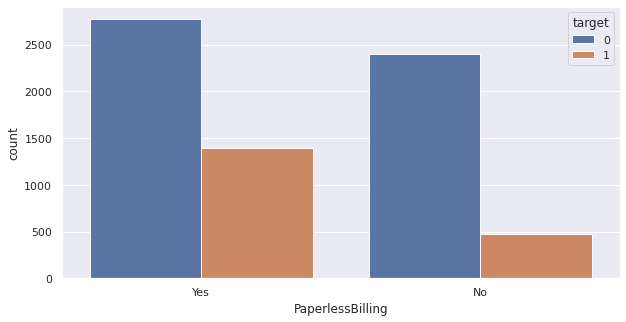

Зависимость целевого от признака: PaymentMethod


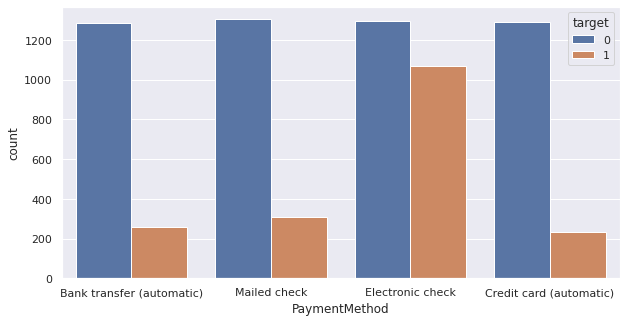

Зависимость целевого от признака: Type


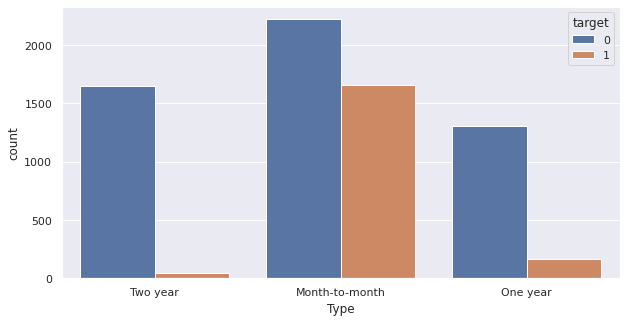

Зависимость целевого от признака: target


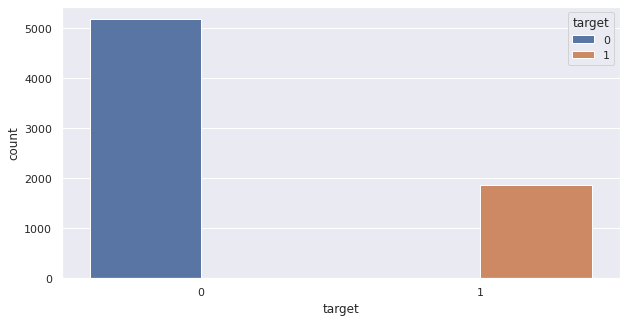

Зависимость целевого от признака: gender


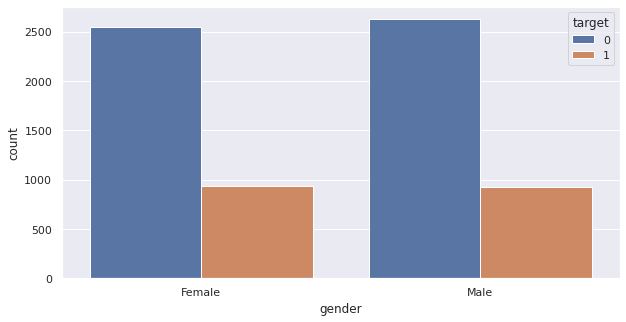

Зависимость целевого от признака: SeniorCitizen


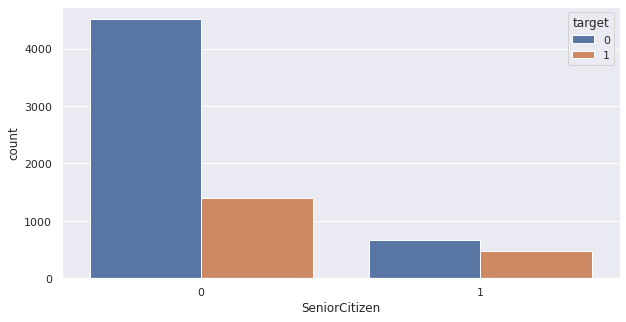

Зависимость целевого от признака: Partner


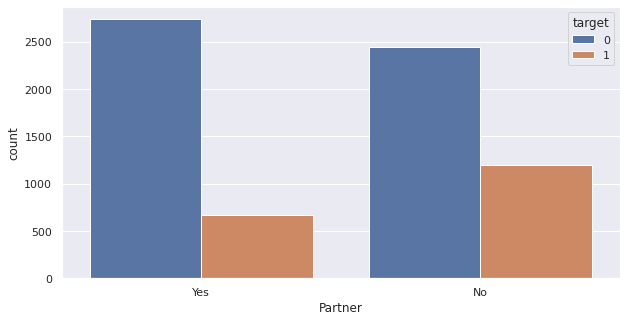

Зависимость целевого от признака: Dependents


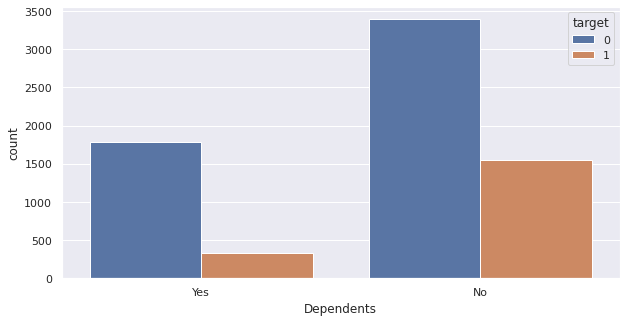

Зависимость целевого от признака: InternetService


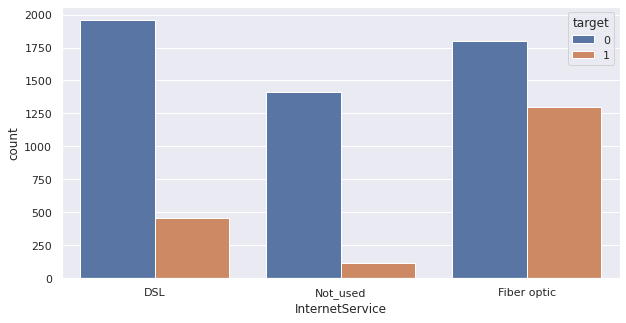

Зависимость целевого от признака: OnlineSecurity


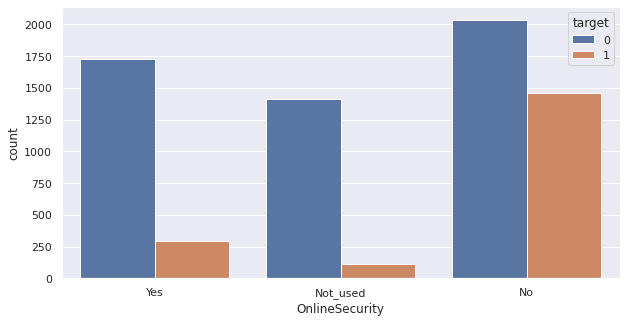

Зависимость целевого от признака: OnlineBackup


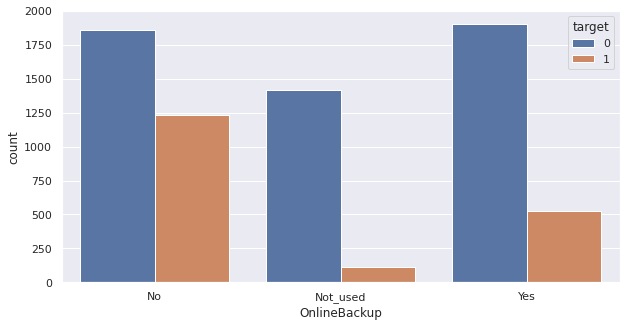

Зависимость целевого от признака: DeviceProtection


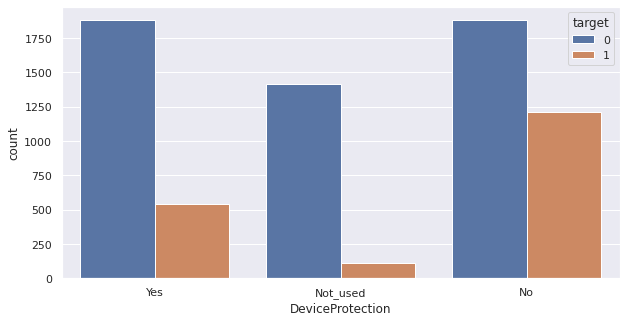

Зависимость целевого от признака: TechSupport


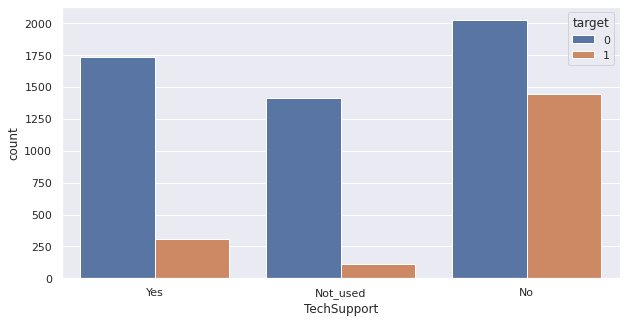

Зависимость целевого от признака: StreamingTV


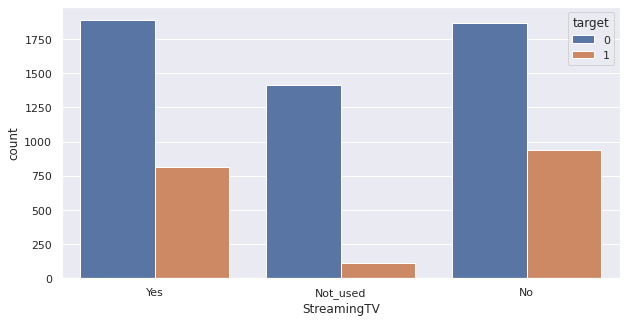

In [43]:
cntplot(data, ('MonthlyCharges','TotalCharges', 'customerID'))

**Вывод:**
- Постарались нарисовать портрет абонента, который откажется от услуг связи:
- **Это человек с ежемесячной оплатой, получающий электронный рассчетный лист, с электронной оплатой, мужчина или женщина, в трудоспособном состоянии, не состоящий в браке, без детей, с подключением через fiber-optic, без блокировки опасных сайтов, без облачного хранилища, без антивируса, без выделенной линии тех.поддержки, без стримингово тв, без каталога фильмов**

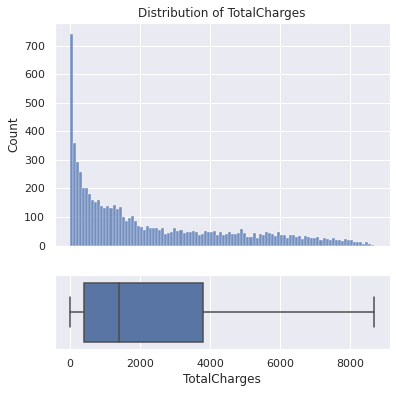

In [44]:
hist_box(data, 'TotalCharges')

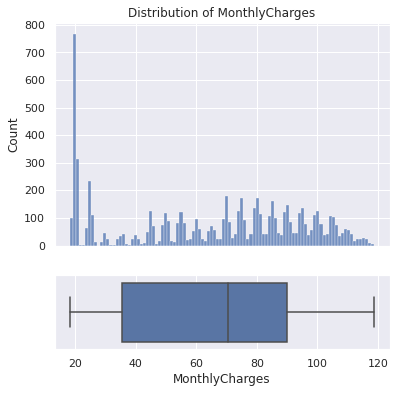

In [45]:
hist_box(data, 'MonthlyCharges')

In [46]:
for c in data[['MonthlyCharges', 'TotalCharges']]:
    print(f'Корреляция спирмена между: {c} и целевым:')
    print(spearmanr(data[c], data['target'])[0].round(3))
    print()

Корреляция спирмена между: MonthlyCharges и целевым:
0.185

Корреляция спирмена между: TotalCharges и целевым:
-0.23



**Вывод:**
- Для численных признаков можно выделить сильную положительную корреляцию между целевым и итоговой суммой оплаты
- ДЛя месячной оплаты корреляция с целевым отсутствует

In [47]:
#признак длительность контракта
data['duration_contract'] = data['EndDate'] - data['BeginDate']
data['duration_contract'] = data['duration_contract'].apply(lambda x: x.days)

In [48]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [49]:
#столбцы для сравнения корреляций
corr_columns = ['PaperlessBilling', 'PaymentMethod',  
 'Type','gender', 'SeniorCitizen', 'Partner', 'Dependents', 
 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
 'TechSupport','StreamingTV', 'StreamingMovies', 'MultipleLines', 'duration_contract']

In [50]:
corr_matrix = pd.DataFrame()
for col1 in corr_columns:
    for col2 in corr_columns:
        corr_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2]).round(3)

In [51]:
data.drop(['BeginDate', 'EndDate'], axis=1, inplace=True)
'BeginDate' and 'EndDate' in data.columns

False

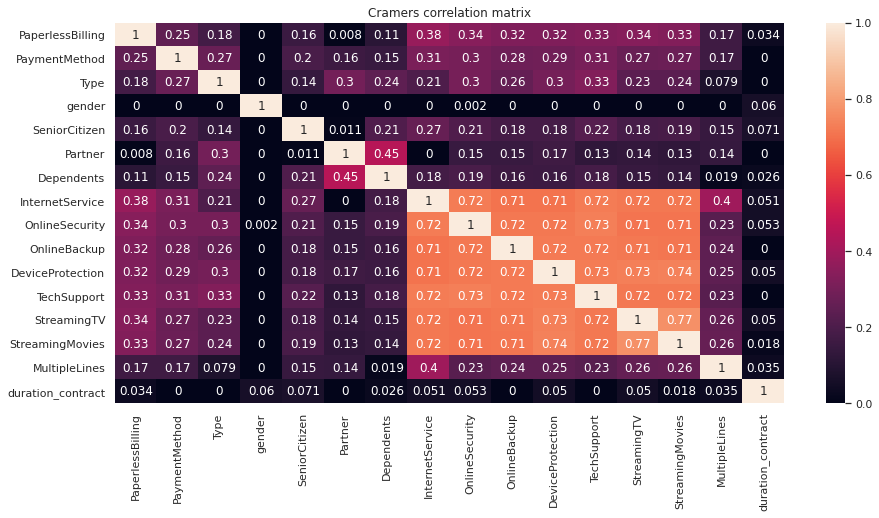

In [52]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(data=corr_matrix, annot=True, ax=ax)
plt.title('Cramers correlation matrix')
plt.show()

**Вывод:**
- Можно выделить сильную корреляцию между BeginDate и ltv = 0.77, это из-за того что один признак сделан из другого
- Признак Type(тип оплаты) коррелирует с целевым на 0.41
- Больше особо нечего выделить, признаки 'BeginDate' и 'EndDate' удалим, т.к только запутают модель

In [53]:
#проверим
data['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

In [54]:
print(f'Таблица contract: \n{contract["TotalCharges"].describe()}')
print(f'Таблица data: \n{data["TotalCharges"].describe()}')

Таблица contract: 
count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64
Таблица data: 
count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64


**Проверим распределение признаков**

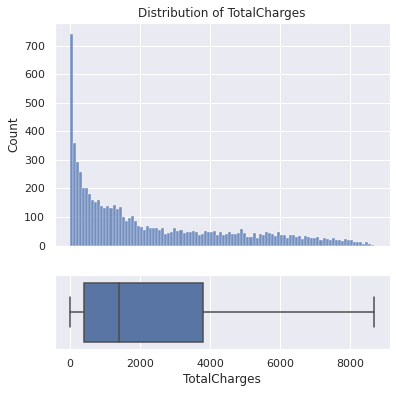

In [55]:
hist_box(data, 'TotalCharges')

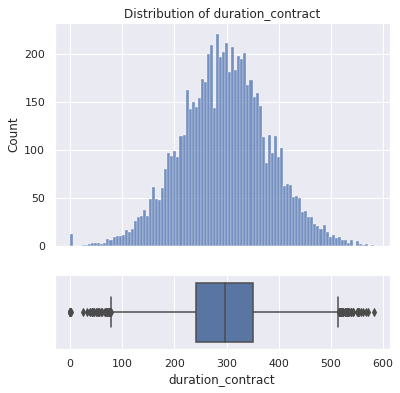

In [56]:
hist_box(data, 'duration_contract')

In [57]:
#пересбросим индексы
data = data.reset_index(drop=True)

**Общий вывод:**
- После объединения числовые признаки остались практически с тем же распределением
- Статистически описали клиентов, которые прекращают использовать услуги
- Изучили график корреляции
***

**Генерация текстовых признаков**

In [58]:
def text_features(row):
    indent = ' '
    test = []
    value = ''.join(row['Type'] + indent + 
             row['PaperlessBilling'] + indent + 
             row['PaymentMethod'] + indent +
             row['gender']+ indent +
             row['Partner'] + indent +
             row['Dependents'] + indent +
             row['InternetService'] + indent +
             row['OnlineSecurity'] + indent +
             row['OnlineBackup'] + indent +
             row['DeviceProtection'] + indent +
             row['TechSupport'] + indent +
             row['StreamingTV'] + indent +
             row['StreamingMovies'] + indent +
             row['MultipleLines'])

    return value

In [61]:
def text_embs(sentences):
    sentences = pd.Series(sentences)
    docs = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(sentences)]
    model = Doc2Vec(vector_size=128, min_count=1, epochs = 20)
    model.build_vocab(docs)
    model.train(docs, total_examples=model.corpus_count,epochs=model.epochs)
    model.save('d2v.model')
    vectors = [model.infer_vector((sentences[i].split())) for i in tqdm(range(0, len(sentences)))]
    return np.array(vectors)

In [65]:
data = data.drop(['customerID'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MonthlyCharges     7043 non-null   float64
 1   PaperlessBilling   7043 non-null   object 
 2   PaymentMethod      7043 non-null   object 
 3   TotalCharges       7043 non-null   float64
 4   Type               7043 non-null   object 
 5   target             7043 non-null   int64  
 6   gender             7043 non-null   object 
 7   SeniorCitizen      7043 non-null   int64  
 8   Partner            7043 non-null   object 
 9   Dependents         7043 non-null   object 
 10  InternetService    7043 non-null   object 
 11  OnlineSecurity     7043 non-null   object 
 12  OnlineBackup       7043 non-null   object 
 13  DeviceProtection   7043 non-null   object 
 14  TechSupport        7043 non-null   object 
 15  StreamingTV        7043 non-null   object 
 16  StreamingMovies    7043 

In [66]:
# Числовые признаки финального датафрейма,
# требующие нормализации
total_new_numeric = ['MonthlyCharges', 'TotalCharges', 'duration_contract']


data[total_new_numeric].head()

,MonthlyCharges,TotalCharges,duration_contract
0,52.55,0.00,0
1,20.25,0.00,0
2,53.85,108.15,479
3,80.85,0.00,0
4,70.70,151.65,279


In [67]:
# Категоиальные признаки финального датафрейма,
# требующие кодирования методом `OneHotEncoder` (для "линейных" моделей) 
# и `OrdinalEncoder` (для "деревянных" моделей).
# Это все признаки, кроме тех, названия которых входят 
# в переменную "total_new_numeric", 
# и признака, содержащего идентификаторы
total_new_categories = []

for i in data.columns:
    if (i not in total_new_numeric) & (i not in ['target']):
        total_new_categories.append(i)

data[total_new_categories].head(5)

,PaperlessBilling,PaymentMethod,Type,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Yes,Bank transfer (automatic),Two year,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Not_used
1,No,Mailed check,Two year,Male,0,No,Yes,Not_used,Not_used,Not_used,Not_used,Not_used,Not_used,Not_used,No
2,Yes,Mailed check,Month-to-month,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,No,Mailed check,Two year,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,Yes,Electronic check,Month-to-month,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [71]:
X = data.drop('target', axis=1)
y = data['target']


X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=RANDOM_STATE)

In [72]:
categorical_cols = [
    'Type', 'PaymentMethod', 'InternetService', 'gender', 'OnlineSecurity', 
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
    'StreamingMovies', 'PaperlessBilling', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines'
]
numeric_cols = ['MonthlyCharges', 'TotalCharges', 'duration_contract']


In [73]:
encoder = OneHotEncoder(drop='first')
encoder.fit(X_train[categorical_cols])

# Прямое кодирование тренировочной выборки
X_train_encoded = encoder.transform(X_train[categorical_cols]).toarray()

X_train = pd.DataFrame(
    np.hstack((X_train[numeric_cols], X_train_encoded)),
    columns=numeric_cols + encoder.get_feature_names().tolist()
)

# Прямое кодирование тестовой выборки
X_test_encoded = encoder.transform(X_test[categorical_cols]).toarray()

X_test = pd.DataFrame(
    np.hstack((X_test[numeric_cols], X_test_encoded)),
    columns=numeric_cols  + encoder.get_feature_names().tolist()
)

In [74]:
# Масштабирование количественных признаков
scaler = StandardScaler()

scaler.fit(X_train[numeric_cols])

X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [75]:
print(X_train.shape, X_test.shape)

(5282, 29) (1761, 29)


### 2. Обучение модели


In [78]:
# scaler = StandardScaler()
# X_train[X_train.loc[:, 0:3].columns] = scaler.fit_transform(X_train[X_train.loc[:, 0:3].columns])
# X_test[X_test.loc[:, 0:3].columns] = scaler.transform(X_test[X_test.loc[:, 0:3].columns])

X_train_torch = torch.FloatTensor(np.array(X_train))
X_test_torch = torch.FloatTensor(np.array(X_test))

y_train_torch = torch.FloatTensor(np.array(y_train))
y_test_torch = torch.FloatTensor(np.array(y_test))

In [79]:
print(X_train.shape, X_test.shape)
print('torch shape:', X_train_torch.shape, X_test_torch.shape)

(5282, 29) (1761, 29)
torch shape: torch.Size([5282, 29]) torch.Size([1761, 29])


In [80]:
def make_predict(model, name, cv):
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc').mean().round(3)
    acc = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean().round(3)
    return name, f'AUC-ROC: {score}, Accuracy: {acc}'

**Net**

In [81]:
#Accuracy, Auc-roc, loss
bacc = BinaryAccuracy()
auc = AUROC(task='binary')
loss = nn.BCELoss()

model = nn.Sequential(
    nn.Linear(29, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid())

In [82]:
#разбиваем на k-фолдов
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE)

In [83]:
metrics = {}
metrics['fold'] = []
metrics['loss'] = []
metrics['auc'] = []
metrics['accuracy'] = []

for fold, (train_index, val_index) in enumerate(kfold.split(X_train_torch)):

    train_X, val_X = X_train_torch[train_index], X_train_torch[val_index]
    train_y, val_y = y_train_torch[train_index], y_train_torch[val_index]
    
    for epoch in tqdm(range(1000)):
        loss_fold = []
        accur_fold = []
        auc_fold = []
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        optimizer.zero_grad()
        predictions = model.forward(train_X).flatten()
        loss_value = loss(predictions, train_y)
        loss_value.backward()
        optimizer.step()
        loss_fold.append(loss_value.cpu().detach().numpy())
        if epoch // 100 > 0:
            with torch.no_grad():
                model.eval()
                val_preds = model.forward(val_X).flatten()
                acc = bacc(val_preds, val_y).item()
                auc_roc = auc(val_preds, val_y).item()
                accur_fold.append(acc)
                auc_fold.append(auc_roc)
                
    metrics['fold'].append(fold)   
    metrics['loss'].append(np.mean(loss_fold))
    metrics['accuracy'].append(np.mean(accur_fold))
    metrics['auc'].append(np.mean(auc_fold))
    
print('Cross-val AUC-ROC:', np.mean(metrics['auc']).round(3))    
print('Cross-val accuracy:', np.mean(metrics['accuracy']).round(3))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Cross-val AUC-ROC: 0.812
Cross-val accuracy: 0.734


**LogisticRegression**

In [84]:
make_predict(LogisticRegression(random_state=RANDOM_STATE, max_iter=3000), 'LogisticRegression', cv=5)

('LogisticRegression', 'AUC-ROC: 0.833, Accuracy: 0.798')

**DecisionTreeClassifier**

In [85]:
make_predict(DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=1, criterion='entropy'), 
             'DecisionTreeClassifier', cv=5)

('DecisionTreeClassifier', 'AUC-ROC: 0.645, Accuracy: 0.738')

**AdaBoostClassifier**

In [86]:
%%time
ada = AdaBoostClassifier(DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=1, criterion='entropy'), 
                   n_estimators=700, random_state=RANDOM_STATE, learning_rate=0.1)

make_predict(ada, 'AdaBoostClassifier', cv=5)

CPU times: user 31.7 s, sys: 241 ms, total: 31.9 s
Wall time: 32 s


('AdaBoostClassifier', 'AUC-ROC: 0.842, Accuracy: 0.796')

**Stacking**

In [87]:
logreg = LogisticRegression(random_state=RANDOM_STATE, max_iter=3000)
logreg.fit(X_train, y_train)

logreg_preds_train = logreg.predict_proba(X_train)[:, 1]
logreg_preds_test = logreg.predict_proba(X_test)[:, 1]

ada.fit(np.hstack([X_train, logreg_preds_train.reshape(-1, 1)]), y_train)
roc_auc_score(y_test, ada.predict_proba(np.hstack([X_test, logreg_preds_test.reshape(-1, 1)]))[:, 1])

0.8603187283143711

In [88]:
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=3000)
clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=1, criterion='entropy'), 
                   n_estimators=100, random_state=0, learning_rate=0.01)

clf.fit(X_train, y_train)
clf_preds_train = clf.predict_proba(X_train)[:, 1]
clf_preds_test = clf.predict_proba(X_test)[:, 1]

lr.fit(np.hstack([X_train, clf_preds_train.reshape(-1, 1)]), y_train)
roc_auc_score(y_test, lr.predict_proba(np.hstack([X_test, clf_preds_test.reshape(-1, 1)]))[:, 1])

0.8510142822561122

In [89]:
make_predict(clf, 'Staking', cv=5)

('Staking', 'AUC-ROC: 0.792, Accuracy: 0.738')

**Вывод:**
- На первом месте LogReg с результатом: 'AUC-ROC: 0.861, Accuracy: 0.79'
- На втором месте модель AdaBoost с результатом: 'AUC-ROC: 0.86, Accuracy: 0.786'
- На третьем месте нейронная сеть Net(131, 128, 128, 1) с результатом: AUC-ROC: 0.858, Accuracy: 0.736
- На четвертом месте Дерево решений с результатом: 'AUC-ROC: 0.785, Accuracy: 0.738'

**Исследуем коэффициент регуляризации в логистической регрессии**

In [90]:
%%time
stats  = {}
for C in range(1, 10+1):
    model = LogisticRegression(random_state=RANDOM_STATE, C=C, max_iter=3000)
    stats[C] = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()

CPU times: user 13.8 s, sys: 15.8 s, total: 29.6 s
Wall time: 29.6 s


In [91]:
max(stats, key=stats.get)
max(stats.values())

print('Лучшее значение С', max(stats, key=stats.get), 'ROC-AUC:', max(stats.values()))

Лучшее значение С 1 ROC-AUC: 0.8326032819337355


**Вывод:**
- С помощью регуляризационного коэффициента не удалось улучшить значение метрики ROC-AUC, возьмем модель AdaBoost

In [92]:
%%time
param_grid = {'max_features': ('sqrt', 'log2'),
              'max_depth' : (1, 2, 3),
              'criterion' :('gini', 'entropy')}

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 336 ms, sys: 2.39 ms, total: 338 ms
Wall time: 349 ms


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=111223),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': (1, 2, 3),
                         'max_features': ('sqrt', 'log2')},
             verbose=True)

**Вывод:**
- После подбора гиперпараметров не получилось улучшить score

In [94]:
%%time
ada = AdaBoostClassifier(DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=1, criterion='entropy'), 
                   n_estimators=700, random_state=RANDOM_STATE, learning_rate=0.01)
ada.fit(X_train, y_train)

CPU times: user 3.38 s, sys: 30.6 ms, total: 3.41 s
Wall time: 3.42 s


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=1,
                                                         random_state=111223),
                   learning_rate=0.01, n_estimators=700, random_state=111223)

In [95]:
#посмотрим важность признаков
ada.feature_importances_

array([0.        , 0.28857143, 0.        , 0.09285714, 0.15428571,
       0.        , 0.05857143, 0.        , 0.18142857, 0.02285714,
       0.        , 0.01857143, 0.02714286, 0.02857143, 0.        ,
       0.02142857, 0.        , 0.01857143, 0.        , 0.01571429,
       0.        , 0.02428571, 0.        , 0.04714286, 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [96]:
indices = [i for i in range(0, len(ada.feature_importances_)) if ada.feature_importances_[i]>0]
indices

[1, 3, 4, 6, 8, 9, 11, 12, 13, 15, 17, 19, 21, 23]

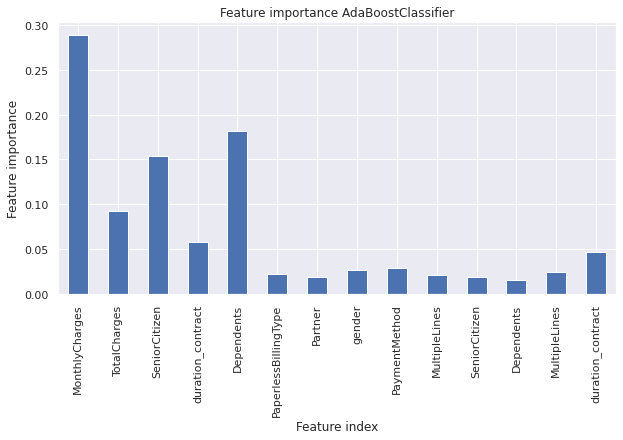

In [97]:

#X.iloc[:, indices].columns
pd.Series(ada.feature_importances_[indices], 
          index=['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'duration_contract','Dependents','PaperlessBilling'\
                'Type','Partner', 'gender','PaymentMethod','MultipleLines','SeniorCitizen','Dependents','MultipleLines','duration_contract'] ).plot(kind='bar')

plt.title('Feature importance AdaBoostClassifier')
plt.xlabel('Feature index')
plt.ylabel('Feature importance')
plt.show()

#list(X.iloc[:, indices].columns[4:])



**Вывод:**
- Исследовали важность признаков у модели AdaBoost, важным они считает признак итоговая сумма за использование, на втором месте месячная оплата и на уровне погрешности признак из текстового описания

**Test AdaBoostClassifier**

In [98]:
#на тестовых
model = ada
model.fit(X_train, y_train)
print('AUC-ROC Test:', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
print('Accuracy Test:', accuracy_score(y_test, model.predict(X_test)))

AUC-ROC Test: 0.854239490034697
Accuracy Test: 0.7938671209540034


**После тестирования модели, мы выяснили что Accuracy нашей модели равняется 0.72**

**Точность определяет, как много отрицательных ответов нашла модель, пока искала положительные. Чем больше отрицательных, тем ниже точность.**

**В данном случает наша модель будет правильно находить клиетнта, которому нужно особое отношение, чтобы не допустить его отток к другому оператору с вероятностью 72%**

In [99]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1275
           1       0.78      0.36      0.49       486

    accuracy                           0.79      1761
   macro avg       0.79      0.66      0.68      1761
weighted avg       0.79      0.79      0.77      1761



In [100]:
predicted_valid = model.predict(X_test)

print(confusion_matrix(y_test,predicted_valid))

[[1225   50]
 [ 313  173]]


- TN = 1275
- TP = 0

- FP = 0
- FN 486

**Описание метрик**

*TP, FP, TN, FN* собираются в одну таблицу — **матрицу ошибок**, или **матрицу неточностей** (англ. *сonfusion matrix)*.

Матрица формируется так:
- по горизонтали («Предсказания») располагаются метки алгоритма от 0 до 1;
- по вертикали («Ответы») — истинные метки класса от 0 до 1.

Что получаем:

- По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:
 - TN в левом верхнем углу;
 - TP в правом нижнем углу.
 
- Вне главной диагонали — ошибочные варианты:
 - FP в правом верхнем углу;
 - FN в левом нижнем углу.
 
----
 
 Что значит истинно положительный ответ (TP)? Модель пометила объект единицей, и его настоящее значение тоже — 1.
 
 В нашей задаче истинно положительный ответ — это количество клиентов, которые:
- по прогнозу модели должны были уйти;
- фактически запросили расторгнуть договор.

---
Если предсказанное и фактическое значение класса отрицательные, ответ истинно отрицательный.

В нашей задаче истинно отрицательный ответ (TN) — это количество клиентов, которые:
- по прогнозу модели не должны были расторгнуть договор;
- фактически не расторгнули договор.
---
Ошибка первого рода — это ложноположительные ответы (FP). Они возникают, когда модель предсказала «1», а вот действительное значение класса — «0».

В нашей задаче ложноположительный ответ — это количество клиентов, которые:
- по прогнозу модели должны были расторгнуть договор;
- фактически не расторгнули.

---

Ошибка второго рода — ложноотрицательные ответы (FN).
Ложноотрицательные ответы появляются, когда модель предсказала «0», а действительное значение класса — «1».

В нашей задаче ложноотрицательный ответ — это количество клиентов, которые:
- по прогнозу модели не должны были уйти;
- фактически ушли.

Анализ матрицы ошибок показывает, что протестированная модель правильно предсказывает большую часть класса 0 (на графике горизонталь «Negative», договор не расторгнут).  Значительно хуже обстоят дела с предсказанием класса 1 (на графике горизонталь «Positive», договор расторгнут). Вывод. Модель эффективно предскажет пользователя, который не собирается расторгать договор

**Вывод:**
- На тестовых данных AUC-ROC модели 0.86, что удовлетворяет условиям заказчика, то есть модель хорошо различает классы, с другой по отчету видно, что модель слабо разбирается в классе 1, но хорошо разбирается в классе 0, т.е понимает кто останется, что тоже можно использовать

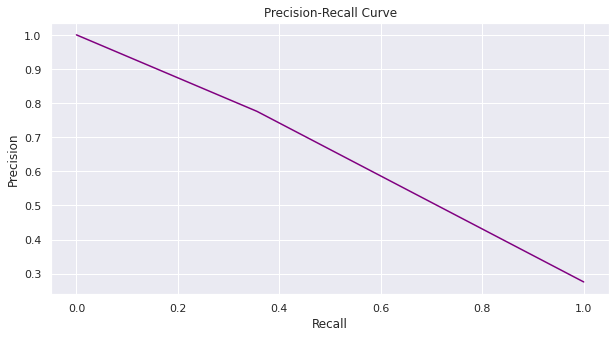

In [101]:
precision, recall, thresholds = precision_recall_curve(y_test, model.predict(X_test))
plt.plot(recall, precision, color='purple')

plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.show() 

**Вывод:**
- Видно что при увеличении полноты точность снижается, это значит что чем больше определяем положительный класс, тем меньше точность

**Проверка на адекватность**

In [102]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:,1])

0.5

# Общий вывод:

- Познакомились с данными, все таблицы оказались на месте, провели исследовательский анализ
- Постарались нарисовать портрет абонента, который откажется от услуг связи:
- Это человек с ежемесячной оплатой, получающий электронный рассчетный лист, с электронной оплатой, мужчина или женщина, в трудоспособном состоянии, не состоящий в браке, без детей, с подключением через fiber-optic, без блокировки опасных сайтов, без облачного хранилища, без антивируса, без выделенной линии тех.поддержки, без стримингово тв, без каталога фильмов
- Попробовали стэкинг моделей т.е использовали вероятности предсказанные adaboost в качестве входного признака для логистической регрессии, получили результат 0.871, а при использовании вероятностей логистической регрессии в adaboost 0.869
---

- На первом месте LogReg с результатом: 'AUC-ROC: 0.861, Accuracy: 0.79'
- На втором месте модель AdaBoost с результатом: 'AUC-ROC: 0.86, Accuracy: 0.786'
- На третьем месте нейронная сеть Net(131, 128, 128, 1) с результатом: AUC-ROC: 0.858, Accuracy: 0.736
- На четвертом месте Дерево решений с результатом: 'AUC-ROC: 0.785, Accuracy: 0.738'
---
**На тесте AdaBoost показала себя с результатом AUC-ROC = 0.851, Accuracy = 0.767**


- Исследовали важность признаков у модели AdaBoost, важным они считает признак итоговая сумма за использование, на втором месте месячная оплата 